In [20]:
import numpy as np
np.random.seed(345)
from tensorflow.random import set_seed
set_seed(3)

In [1]:
import shutil
from collections import defaultdict
import json
from pathlib import Path
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn import datasets
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dropout,Flatten,Dense,Activation, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
tf.keras.backend.clear_session()
from tensorflow.keras.callbacks import CSVLogger
import time
from datetime import datetime

In [22]:
keras.__version__, tf.__version__

('2.5.0', '2.5.0')

In [23]:
train = './car_color/train/'
test = './car_color/test/'
val = './car_color/val/'
annot_err = './car_color/annotation-error.txt'

In [24]:
def count_images(dataset):
    """
    dataset: 'train/' or 'test/'
    """
    v = []
    for i in sorted(os.listdir(dataset)):
        v.append(len(os.listdir(dataset+i)))
    df = pd.DataFrame({'color': sorted(os.listdir(dataset)), 'count': v})
    return(df)

In [25]:
df = count_images(train)

In [26]:
class_subset = sorted(os.listdir(train))

In [27]:
class_subset

['beige', 'black', 'blue', 'brown', 'red', 'silver', 'white', 'yellow']

In [28]:
isize = 224

In [29]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet',input_shape=(isize, isize, 3), pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(len(class_subset), activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
train_generator = ImageDataGenerator(
    rescale=1/255.,              
    brightness_range=None,
    width_shift_range=0.5,
    rotation_range=False,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.3
    preprocessing_function=
)

valid_generator = ImageDataGenerator(rescale=1/255.)

In [31]:
test_generator = ImageDataGenerator(rescale=1./255)

In [32]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [33]:
def dataframe_keras(sourcedir, removal_files, textdir):
    """Automatically returns a DataFrame that can be used in flow_from_dataframe method.
    sourcedir: where the data folders corresponding to each class live, for ex. 'fashion-train/'
    Each class is in a different folder.
    removal_files: indicate 'yes' if specific image files need to be removed, for instance because of annotation errors.
    textdir: directory where a textfile can be found with files to be removed.
    """
    
    coll_labelnames = []
    coll_idfiles = []

    for i in os.listdir(sourcedir):
        idfiles = os.listdir(os.path.join(sourcedir, i))
        
        labelnames = len(idfiles) * [str(i)]

        
        coll_labelnames.append(labelnames)
        coll_idfiles.append(idfiles)

    df = pd.DataFrame({'label': flatten(coll_labelnames), 'idfiles': flatten(coll_idfiles)})
    df['id'] = str(sourcedir) + df['label'] + '/' + df['idfiles']
    print()
    print('Raw data before removal has shape:', df.shape)
    
    # removes image files that are mentioned in textfile.
        
    if removal_files == 'yes':
        with open(textdir) as f:
            files_to_remove = f.read().splitlines()
        files_to_remove = list(filter(lambda x: 'jpg' in x, files_to_remove))
        print('Number of image files to be removed:', len(files_to_remove))
        df = df[~df['idfiles'].isin(files_to_remove)]
        print('Raw data after removal has shape:', df.shape)
    else:
        print('No images removed')
    
    return(df)

In [34]:
traindf = dataframe_keras(train, 'yes', annot_err)
validdf = dataframe_keras(val, 'yes', annot_err)


Raw data before removal has shape: (7269, 3)
Number of image files to be removed: 64
Raw data after removal has shape: (7228, 3)

Raw data before removal has shape: (1557, 3)
Number of image files to be removed: 64
Raw data after removal has shape: (1557, 3)


In [35]:
traindf.head()

,label,idfiles,id
0,beige,00073f9e04.jpg,./car_color/train/beige/00073f9e04.jpg
1,beige,00acfc482e.jpg,./car_color/train/beige/00acfc482e.jpg
2,beige,00b347d81d.jpg,./car_color/train/beige/00b347d81d.jpg
3,beige,00ecfeedea.jpg,./car_color/train/beige/00ecfeedea.jpg
4,beige,012d5b3f87.jpg,./car_color/train/beige/012d5b3f87.jpg


In [36]:
BATCH_SIZE = 32

In [37]:
traingen=train_generator.flow_from_dataframe(
    dataframe=traindf,
    directory=None,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    target_size=(isize, isize))

validgen=valid_generator.flow_from_dataframe(
    dataframe=validdf,
    directory=None,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    target_size=(isize, isize))

Found 7228 validated image filenames belonging to 8 classes.
Found 1557 validated image filenames belonging to 8 classes.


In [38]:
print(traingen[0])

(array([[[[0.454902  , 0.45098042, 0.47058827],
         [0.454902  , 0.45098042, 0.47058827],
         [0.454902  , 0.45098042, 0.47058827],
         ...,
         [0.36078432, 0.3529412 , 0.35686275],
         [0.37503552, 0.3671924 , 0.37111396],
         [0.38823533, 0.3803922 , 0.38431376]],

        [[0.454902  , 0.45098042, 0.47058827],
         [0.454902  , 0.45098042, 0.47058827],
         [0.454902  , 0.45098042, 0.47058827],
         ...,
         [0.36078432, 0.3529412 , 0.35686275],
         [0.37503552, 0.3671924 , 0.37111396],
         [0.38823533, 0.3803922 , 0.38431376]],

        [[0.45882356, 0.454902  , 0.47450984],
         [0.45882356, 0.454902  , 0.47450984],
         [0.45882356, 0.454902  , 0.47450984],
         ...,
         [0.20392159, 0.19607845, 0.20000002],
         [0.22631633, 0.2184732 , 0.22239476],
         [0.24705884, 0.2392157 , 0.24313727]],

        ...,

        [[0.2901961 , 0.2901961 , 0.2901961 ],
         [0.2901961 , 0.2901961 , 0.2901961 

In [44]:
t1 = time.time()/60

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE
n_epochs = 80

csv_logger = CSVLogger('training.log', separator=',', append=False)

checkpointer = ModelCheckpoint(filepath='EFN-model.best.h5', 
                               verbose=1, 
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = model.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, csv_logger],
                    verbose=True,
                    shuffle = True,
                    workers=4)

t2 = time.time()/60
print("Duration:", t2-t1)

Epoch 1/80


KeyboardInterrupt: 

In [22]:
model.save_weights("EFN-model.best.weight.h5")

In [23]:
model = load_model('EFN-model.best.h5')

In [24]:
class_subset = sorted(os.listdir(test))

In [25]:
test_generator = ImageDataGenerator(rescale=1./255)

In [26]:
testgen = test_generator.flow_from_directory(test,
                                               target_size=(isize, isize),
                                               batch_size=1,
                                               class_mode=None,
                                               classes=class_subset,
                                               shuffle=False
                                               )

Found 1515 images belonging to 8 classes.


In [37]:
import time

In [42]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3617013448829512627,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7781482496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16444211606849157720
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:65:00.0, compute capability: 8.6"]

In [41]:
!nvidia-smi

Fri Nov 25 17:36:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:65:00.0  On |                  N/A |
|  0%   38C    P8    13W / 370W |   9021MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [39]:
start = time.time()
model_predict = model.predict(testgen) #1515 images
print("time :", time.time() - start)

time : 60.498509645462036


In [28]:
model_predict.shape

(1515, 8)

In [29]:
df_testprediction = pd.DataFrame(model_predict, index=testgen.filenames, columns=class_subset)

In [30]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
df_testprediction

,beige,black,blue,brown,red,silver,white,yellow
beige\029fcc83af.jpg,0.9788,0.0000,0.0000,0.0002,0.0000,0.0198,0.0011,0.0000
beige\02e37c0e56.jpg,0.6786,0.0003,0.0004,0.0072,0.0003,0.3123,0.0009,0.0002
beige\05aeb6ddec.jpg,0.9480,0.0001,0.0002,0.0461,0.0001,0.0049,0.0001,0.0004
beige\096d430280.jpg,0.9997,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0001
beige\0a6e186cc0.jpg,0.9959,0.0000,0.0000,0.0031,0.0000,0.0004,0.0000,0.0004
...,...,...,...,...,...,...,...,...
yellow\fd1da2f797.jpg,0.0002,0.0000,0.0000,0.0006,0.0003,0.0000,0.0000,0.9990
yellow\fd3d2525fb.jpg,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
yellow\feacf53e9e.jpg,0.0001,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.9997
yellow\feeded3e6e.jpg,0.0009,0.0004,0.0001,0.0281,0.0001,0.0003,0.0000,0.9702


In [31]:
predicted_classes = np.argmax(model.predict(testgen), axis=-1) #model.predict_classes(testgen). Argmax returns indices of max values
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

In [32]:
len(predicted_classes)

1515

In [33]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]), color=("green" if pred_idx == true_idx else "red"))
    fig.savefig('testgallery.png')

In [34]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 95.38%


,Precision,Recall,F-Score,Support
red,1.0000,0.9926,0.9963,136.0000
blue,0.9949,0.9848,0.9898,198.0000
yellow,0.9840,0.9919,0.9880,124.0000
white,0.9732,0.9703,0.9718,337.0000
black,0.9507,0.9680,0.9593,219.0000
beige,0.8859,0.9261,0.9056,176.0000
brown,0.9459,0.8678,0.9052,121.0000
silver,0.9024,0.9069,0.9046,204.0000


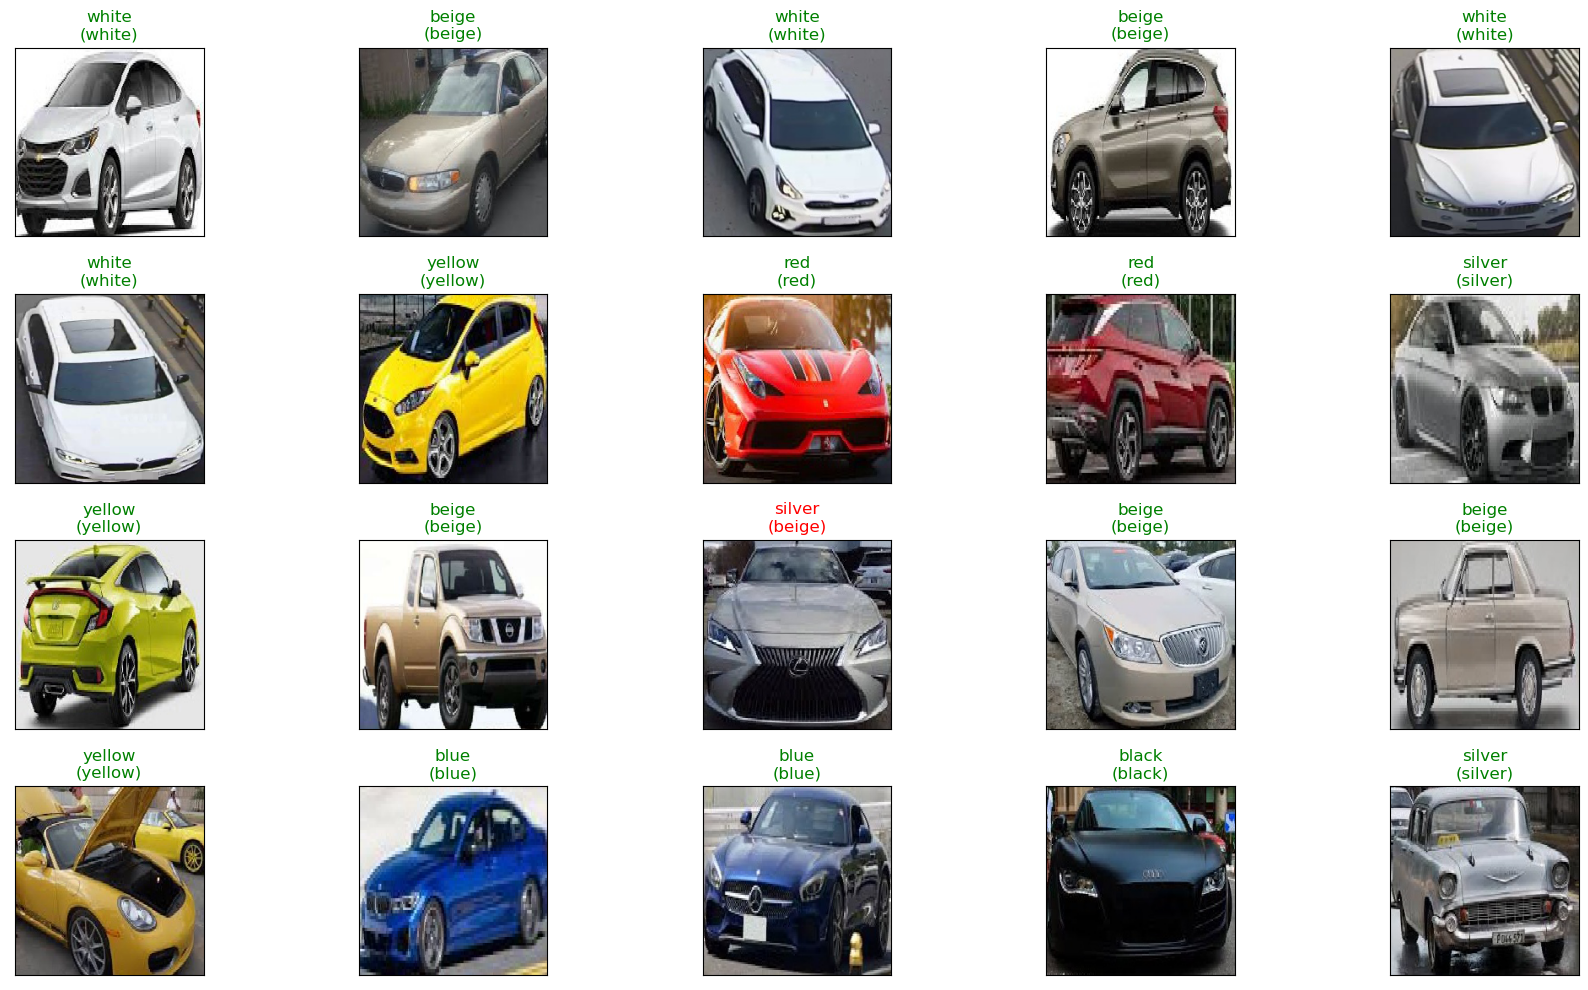

In [35]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [36]:
pd.DataFrame(confusion_matrix(true_classes, predicted_classes), index=list(class_indices.values()), columns=list(class_indices.values()) )

,beige,black,blue,brown,red,silver,white,yellow
beige,163,0,0,4,0,7,0,2
black,2,212,1,0,0,4,0,0
blue,0,1,195,1,0,1,0,0
brown,10,3,0,105,0,2,1,0
red,0,1,0,0,135,0,0,0
silver,4,6,0,1,0,185,8,0
white,4,0,0,0,0,6,327,0
yellow,1,0,0,0,0,0,0,123


In [ ]:
def color_tag(sourcedir, imin, isize, thr):
    """
    Displays dominant colors beyond a given threshold.
    sourcedir: directory where image can be found, for ex.: '/home/administrateur/Documents/RR/colors/fashion-train/purple'
    imin : image input, for ex 'blue-car.jpg'
    isize: input image size, for ex. 224
    thr: chosen threshold value
    """
    
    image = tf.keras.preprocessing.image.load_img(os.path.join(sourcedir, imin), target_size=(isize, isize))
    data = asarray(image)
    ndata = np.expand_dims(data, axis=0)
    y_prob = model.predict(ndata/255)
    y_prob.argmax(axis=-1)
    
    print('color', [sorted(os.listdir(train))[i] for i in np.where(np.ravel(y_prob)>thr)[0]])
    print('values', [np.ravel(y_prob)[i] for i in list(np.where(np.ravel(y_prob)>thr)[0])])

In [2]:
model = load_model('EFN-model.best.h5')

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 112, 112, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 112, 112, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 113, 113, 14  0          ['block2a_expand_activation[0][0]
 g2D)                           4)                               ']                               
                                                                                                  
 block2a_d

 block2c_dwconv (DepthwiseConv2  (None, 56, 56, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 56, 56, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 56, 56, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePoolin

 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block3b_se_reduce[0][0]']      
          

 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 14, 14, 288)  0           ['block4a_activation[0][0]',     
          

                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 14, 14, 96)   55296       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 14, 14, 96)  384         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 14, 14, 96)   0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 14, 14, 96)   0           ['block4c_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block4e_drop (Dropout)         (None, 14, 14, 96)   0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_add (Add)              (None, 14, 14, 96)   0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 14, 14, 576)  55296       ['block4e_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 14, 14, 576)  2304       ['block5a_expand_conv[0][0]']    
 ization) 

 ization)                                                                                         
                                                                                                  
 block5c_expand_activation (Act  (None, 14, 14, 816)  0          ['block5c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 14, 14, 816)  20400      ['block5c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 14, 14, 816)  3264       ['block5c_dwconv[0][0]']         
 )                                                                                                
          

 block5e_dwconv (DepthwiseConv2  (None, 14, 14, 816)  20400      ['block5e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5e_bn (BatchNormalization  (None, 14, 14, 816)  3264       ['block5e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5e_activation (Activation  (None, 14, 14, 816)  0          ['block5e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 816)         0           ['block5e_activation[0][0]']     
 agePoolin

 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1392)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6b_se_reduce[0][0]']      
          

 block6d_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, 7, 7, 1392)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 7, 7, 232)    322944      ['block6d_se_excite[0][0]']      
          

                                                                                                  
 block6f_se_excite (Multiply)   (None, 7, 7, 1392)   0           ['block6f_activation[0][0]',     
                                                                  'block6f_se_expand[0][0]']      
                                                                                                  
 block6f_project_conv (Conv2D)  (None, 7, 7, 232)    322944      ['block6f_se_excite[0][0]']      
                                                                                                  
 block6f_project_bn (BatchNorma  (None, 7, 7, 232)   928         ['block6f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6f_drop (Dropout)         (None, 7, 7, 232)    0           ['block6f_project_bn[0][0]']     
          

                                                                                                  
 block7b_add (Add)              (None, 7, 7, 384)    0           ['block7b_drop[0][0]',           
                                                                  'block7a_project_bn[0][0]']     
                                                                                                  
 top_conv (Conv2D)              (None, 7, 7, 1536)   589824      ['block7b_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 7, 7, 1536)   6144        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 7, 7, 1536)   0           ['top_bn[0][0]']                 
                                                                                                  
 max_pool 

In [36]:
import cv2
import os

In [22]:
label = ['beige', 'black', 'blue' , 'brown', 'red', 'silver', 'white', 'yellow']

In [49]:
files = os.listdir('./color_test/')
path = './color_test/'

In [ ]:
for idx, file in enumerate(files):
    try:
        
        src = cv2.imread(path + file)
        _, h = src.shape[:2]
        src = src[h//2:, :]
        src_hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
        result = color_classification2(src_hsv)
        src = cv2.resize(src, (224, 224))
        src = src.reshape(1,224,224,3)
        y_prob = model.predict(src, verbose=0)
        print(f"{idx+1}{file} {result} : {label[y_prob.argmax()]}")
        cv2.imshow('src', src)
        cv2.waitKey()
        cv2.destroyAllWindows()
    except:
        pass

1black100.jpg black : blue
2black101.jpg gray : white
3black102.jpg black : red
4black103.jpg black : black
5black104.jpg black : white
6black105.jpg black : white
7black106.jpg black : white
8black107.jpg black : silver
9black108.jpg black : blue
10black109.jpg blue : silver
11black110.jpg gray : brown
12black111.jpg black : beige
13black112.jpg gray : beige
14black113.jpg black : silver
15black114.jpg black : white
16black115.jpg black : white
17black116.jpg black : red
18black117.jpg black : beige
19black118.jpg black : black
20black119.jpg black : black
21black120.jpg black : silver
22black121.jpg black : black
23black122.jpg black : white
24black123.jpg black : white
25black124.jpg black : white
26black125.jpg gray : silver
27black126.jpg black : white
28black127.jpg black : black
29black128.jpg black : brown
30black129.jpg blue : brown
31black130.jpg black : black
32black131.jpg black : white


In [45]:
print(y_prob.argmax())

2


In [47]:
def color_classification2(src_hsv):
    color = ['red', 'blue', 'yellow', 'black', 'white', 'gray']
    
    # red
    red_hsv1 = cv2.inRange(src_hsv, (0, 50, 50), (15, 255, 255))
    red_hsv2 = cv2.inRange(src_hsv, (165, 50, 50), (180, 255, 255))
    red_mask = red_hsv1 | red_hsv2
    red_mean = np.mean(red_mask)

    # blue
    blue_mask = cv2.inRange(src_hsv, (90, 50, 50), (130, 255, 255))
    blue_mean = np.mean(blue_mask)
    
    # yellow
    yellow_mask = cv2.inRange(src_hsv, (20, 50, 50), (35, 255, 255))
    yellow_mean = np.mean(yellow_mask)

    # black
    black_mask = cv2.inRange(src_hsv, (0, 0, 0), (180, 255, 70))
    black_mean = np.mean(black_mask)

    # white
    white_mask = cv2.inRange(src_hsv, (0, 0, 200), (180, 255, 255))
    white_mean = np.mean(white_mask)
    
    # gray
    gray_mask = cv2.inRange(src_hsv, (0, 0, 50), (180, 30, 230))
    gray_mean = np.mean(gray_mask)
    
    arr = [red_mean, blue_mean, yellow_mean, black_mean, white_mean, gray_mean]
    
    return color[arr.index(max(arr))]

In [35]:
arr = [red_mean, blue_mean, yellow_mean, black_mean, white_mean, gray_mean]
arr

[0.0,
 70.26622619510299,
 0.0,
 125.60046638165565,
 6.899672422408528,
 95.43917605907501]